# Resources

Nice Example:
https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut1_students_with_answers.html

# Implementation of BNN

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn

In [20]:
#import and clean data
x_names = ['L', 'b1', 'b2', 'alpha_l', 'b_sec1_b1', 'b_sec2_b1', 'b_sec1_b2', 'b_sec2_b2', 'l_sec', 't_p', 't_w', 'h_w', 'h_F', 'h_S1_3', 'h_S7_9', 'h_v', 'l_v', 'h_b', 'b_b', 'fcc', 'fsy', 'fsu', 'esu', 'd_p_1_o']
#x_names=['L']
y_names=['sf3']
data=pd.concat([pd.read_csv("TestData\\5_CFBSamples.csv")[x_names], pd.read_csv("TestData\\SumRes_5.csv")[y_names]], axis=1)
data=data[data['sf3']<100]
#print(data.head())
data.dropna(axis=0,inplace=True)
x_data=data[x_names]
x_tensor = torch.tensor(x_data.values).float().squeeze()
y_data=data[y_names]
y_tensor = torch.tensor(y_data.values).float().squeeze()
# x_tensor[x_tensor.isnan()=='None']
# x_tensor[0].type()
print(data.head())

       L     b1     b2  alpha_l  b_sec1_b1  b_sec2_b1  b_sec1_b2  b_sec2_b2  \
0   4022  34617  11604      105   0.082445   0.133854   0.050126   0.221380   
1   7396  21146  30266      112   0.221754   0.075967   0.118312   0.413218   
2   9413   8674  21126      113   0.384995   0.259767   0.228504   0.392493   
3  15649  14750  23590      109   0.381682   0.383867   0.363267   0.119643   
4  15346  15945   9534       61   0.185609   0.369041   0.436453   0.296419   

      l_sec   t_p  ...  h_v  l_v  h_b  b_b  fcc         fsy         fsu  \
0  0.404236   892  ...    0    0    0    0   60  600.000679  850.000131   
1  0.121881  1052  ...    0    0    0    0   80  600.000657  850.000016   
2  0.188618   537  ...    0    0    0    0   80  600.000889  850.000573   
3  0.300199   449  ...    0    0    0    0   40  600.000392  850.000120   
4  0.434912   413  ...    0    0    0    0   45  600.000935  850.000953   

        esu  d_p_1_o        sf3  
0  0.800005       16  36.718483  
1  0.8

In [21]:
data['sf3'].describe()

count    2635.000000
mean       25.386773
std        24.625669
min         0.000000
25%         6.100736
50%        17.192089
75%        37.411983
max        99.479034
Name: sf3, dtype: float64

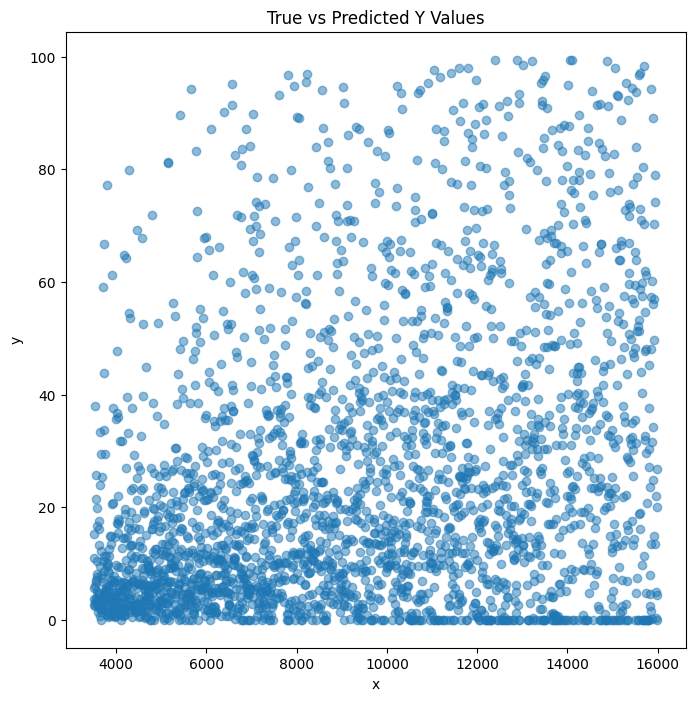

In [22]:
# Plot true vs predicted values
plt.figure(figsize=(8, 8))
plt.scatter(x_data['L'], y_data, alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('True vs Predicted Y Values')
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')  # Perfect predictions line
plt.show()

In [23]:
# train, test split

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_tensor, y_tensor, test_size=0.2, random_state=42)
#x_train = x_train.reshape(-1, 1)
#y_train = y_train.reshape(-1, 1)
print(x_train.shape)

print(x_train)
print(y_train)

torch.Size([2108, 24])
tensor([[7.5660e+03, 1.6289e+04, 1.0533e+04,  ..., 8.5000e+02, 8.0000e-01,
         1.2000e+01],
        [1.0007e+04, 2.2958e+04, 2.0518e+04,  ..., 8.5000e+02, 8.0000e-01,
         1.4000e+01],
        [4.8560e+03, 1.0857e+04, 9.0410e+03,  ..., 8.5000e+02, 8.0001e-01,
         1.4000e+01],
        ...,
        [8.2200e+03, 3.0125e+04, 1.3685e+04,  ..., 8.5000e+02, 8.0001e-01,
         1.6000e+01],
        [1.1968e+04, 3.1101e+04, 2.3177e+04,  ..., 8.5000e+02, 8.0000e-01,
         2.6000e+01],
        [9.5300e+03, 3.1564e+04, 2.8493e+04,  ..., 8.5000e+02, 8.0000e-01,
         3.0000e+01]])
tensor([10.8579,  9.1174,  2.3693,  ..., 97.0042, 26.7887,  8.6675])


In [24]:
from sklearn.preprocessing import MinMaxScaler
import torch

# Convert tensors to numpy arrays
x_train_np = x_train.numpy()
x_val_np = x_val.numpy()

# Initialize the MinMaxScaler and fit it on the training data
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_np)

# Scale the validation data using the same scaler
x_val_scaled = scaler.transform(x_val_np)

# Convert the scaled arrays back to tensors
x_train = torch.tensor(x_train_scaled, dtype=torch.float32)
x_val = torch.tensor(x_val_scaled, dtype=torch.float32)

In [25]:
mean = x_train.mean(dim=0)
print(mean)
std = x_train.std(dim=0)
print(std)
mean = y_train.mean(dim=0)
print(mean)
std = y_train.std(dim=0)
print(std)

tensor([0.4734, 0.4843, 0.5079, 0.4904, 0.4971, 0.5013, 0.5097, 0.5086, 0.4884,
        0.4798, 0.5035, 0.5086, 0.4998, 0.5077, 0.4985, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4133, 0.5080, 0.5158, 0.5037, 0.4232])
tensor([0.2856, 0.2849, 0.2817, 0.2876, 0.2854, 0.2880, 0.2875, 0.2864, 0.2910,
        0.2892, 0.2896, 0.2903, 0.2900, 0.2906, 0.2906, 0.0000, 0.0000, 0.0000,
        0.0000, 0.2908, 0.2984, 0.2952, 0.2889, 0.2752])
tensor(25.6794)
tensor(24.7352)


In [26]:
# # Normalisation

# mean = x_train.mean(dim=0)
# std = x_train.std(dim=0)

# x_train_normalized = (x_train - mean) / std
# x_val_normalized = (x_val - mean) / std

# # Handling potential division by zero if a feature has constant value (std = 0)
# x_train_normalized[torch.isnan(x_train_normalized)] = 0
# x_val_normalized[torch.isnan(x_val_normalized)] = 0

In [27]:
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.):
        super().__init__()

        self.activation = nn.Tanh()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        # x = x.reshape(-1, 1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        # print("mu shape:", mu.shape)
        # print("sigma shape:", sigma.shape)
        # print("y shape:", y.shape)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)

        
        return mu

In [28]:
x_train.shape

torch.Size([2108, 24])

In [29]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from tqdm.auto import trange
pyro.clear_param_store()

model = BNN(in_dim=24, out_dim=1, hid_dim=20, n_hid_layers=10, prior_scale=5.)
mean_field_guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.01})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 2500
progress_bar = trange(num_epochs)


losses = []
for epoch in progress_bar:
    loss = svi.step(x_train, y_train)
    avg_loss = loss / x_train.shape[0]
    losses.append(avg_loss)
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/2500 [00:00<?, ?it/s]

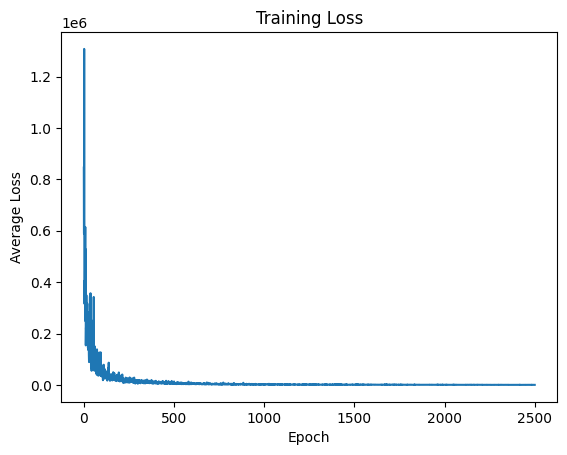

In [30]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.show()

In [31]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=mean_field_guide, num_samples=500)
preds = predictive(x_val)

In [32]:
preds['sigma']

tensor([[0.8652],
        [0.8870],
        [0.9508],
        [0.8552],
        [0.8875],
        [0.8810],
        [0.8911],
        [0.8613],
        [0.9161],
        [0.9213],
        [0.9348],
        [1.0603],
        [0.8691],
        [0.9791],
        [0.9345],
        [0.8975],
        [0.8356],
        [0.9334],
        [0.9708],
        [1.0013],
        [0.8737],
        [0.8839],
        [0.8790],
        [0.9582],
        [0.9143],
        [0.9056],
        [0.8388],
        [0.8684],
        [1.0108],
        [0.7947],
        [0.9539],
        [0.8088],
        [0.7486],
        [0.9026],
        [0.7991],
        [0.9499],
        [0.9334],
        [0.9755],
        [0.9413],
        [1.0113],
        [0.7790],
        [0.8888],
        [0.8240],
        [0.8830],
        [0.9164],
        [0.9400],
        [0.8991],
        [0.8252],
        [0.8785],
        [0.9255],
        [0.8298],
        [0.8697],
        [0.8802],
        [0.8632],
        [0.8719],
        [0

In [38]:
predicted_y_mean = preds['obs'].mean(0)
predicted_y_mean

tensor([24.6791, 24.7551, 24.7129, 24.7084, 24.7453, 24.7580, 24.7787, 24.7569,
        24.6864, 24.7925, 24.7553, 24.8035, 24.7319, 24.6828, 24.8255, 24.7445,
        24.7149, 24.7429, 24.7423, 24.7133, 24.7532, 24.7089, 24.7211, 24.7692,
        24.7891, 24.7821, 24.7194, 24.6896, 24.7100, 24.6951, 24.7839, 24.7005,
        24.7655, 24.7092, 24.7664, 24.7548, 24.7541, 24.7672, 24.7426, 24.7095,
        24.8244, 24.7762, 24.6839, 24.7310, 24.7002, 24.7281, 24.7635, 24.7423,
        24.6866, 24.7034, 24.7902, 24.7410, 24.6944, 24.7745, 24.7221, 24.8236,
        24.7518, 24.7708, 24.7787, 24.7318, 24.7014, 24.7618, 24.7368, 24.7038,
        24.6813, 24.7372, 24.7112, 24.7670, 24.7613, 24.7610, 24.7521, 24.7204,
        24.7270, 24.7513, 24.7744, 24.7438, 24.7455, 24.7637, 24.7547, 24.7251,
        24.6566, 24.6927, 24.7362, 24.7429, 24.7086, 24.7165, 24.7667, 24.7390,
        24.7734, 24.7307, 24.7142, 24.7848, 24.7201, 24.7279, 24.7152, 24.7517,
        24.7039, 24.7832, 24.7700, 24.77

In [34]:
# y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
# print(y_pred)
y_pred= preds['obs'][0]
print(y_pred)

tensor([26.3298, 24.9577, 26.1294, 26.2103, 24.0081, 26.1809, 25.1868, 26.4616,
        25.1378, 24.3810, 25.8143, 23.6373, 25.7299, 25.6572, 24.7413, 24.9597,
        25.4359, 25.2161, 24.9436, 24.5709, 25.4514, 25.2222, 24.7424, 26.3162,
        26.6936, 24.4025, 26.3090, 24.9264, 24.1256, 25.9724, 26.6319, 26.0905,
        25.9681, 26.0395, 25.4334, 25.2699, 26.1697, 25.7370, 24.8990, 25.9354,
        25.7428, 27.8574, 25.3774, 26.7436, 25.4490, 24.8658, 25.6533, 24.5249,
        24.7814, 25.4533, 25.1750, 24.7646, 25.9941, 25.8497, 25.9673, 24.7753,
        25.8209, 24.9991, 25.1542, 25.0374, 25.7721, 25.2724, 25.2815, 25.7407,
        26.2418, 26.1614, 24.2242, 25.8313, 24.0246, 25.3986, 27.3768, 25.7374,
        26.2264, 25.5076, 26.0178, 24.6165, 25.3538, 25.2398, 24.4010, 25.7195,
        25.0989, 25.7686, 25.9978, 25.2750, 26.8035, 26.0866, 24.7791, 25.4537,
        24.3867, 25.9667, 25.8279, 26.5249, 26.3779, 25.2412, 24.5655, 25.3539,
        24.5238, 25.1848, 25.5631, 25.17

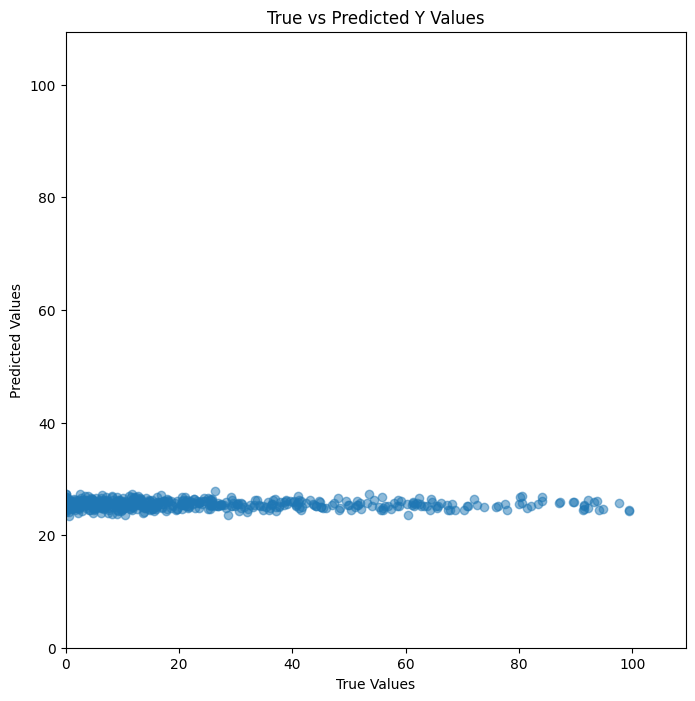

In [43]:
# Plot true vs predicted values
plt.figure(figsize=(8, 8))
plt.scatter(y_val, y_pred, alpha=0.5)
max_value = max(y_val.max(), y_pred.max())
min_value = min(y_val.min(), y_pred.min())
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Y Values')
plt.xlim(-0.1 * min_value, 1.1 * max_value)
plt.ylim(-0.1 * min_value, 1.1 * max_value)
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')  # Perfect predictions line
plt.show()

In [40]:
#Assuming y_val and y_pred are PyTorch tensors
# Calculate the squared differences
squared_diff = (y_val - y_pred) ** 2

# Calculate the mean of squared differences
mean_squared_diff = torch.mean(squared_diff)

# Calculate RMSE
rmse = torch.sqrt(mean_squared_diff)

print("Root Mean Squared Error (RMSE):", rmse.item())

Root Mean Squared Error (RMSE): 24.238300323486328


In [41]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    # xlims = [-0.5, 1.5]
    # ylims = [-1.5, 2.5]
    # plt.xlim(xlims)
    # plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    #ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(x_train[:, 0] , y_train, 'ko', markersize=4, label="observations")
    ax.plot(x_train[:, 0], y_train, 'ko', markersize=3)
    ax.plot(x_val[:, 0], y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
    ax.fill_between(x_val[:, 0], y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plt.legend(loc=4, fontsize=15, frameon=False)

In [42]:
x_train[:, 0]

tensor([0.3251, 0.5205, 0.1083,  ..., 0.3775, 0.6774, 0.4823])

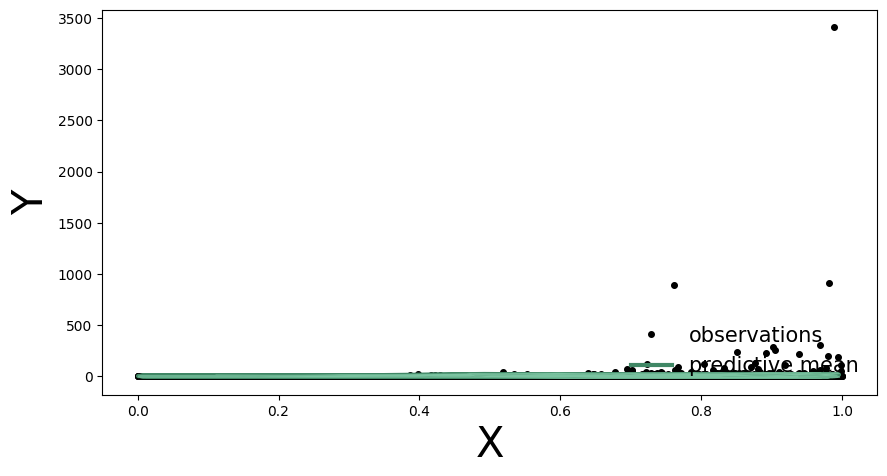

In [84]:
plot_predictions(preds)